# 1 Import and Install Dependencies


In [1]:
!pip install tensorflow==2.9.1 tensorflow-gpu==2.9.1 opencv-python mediapipe pyttsx3 sklearn matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [50]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [51]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [52]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [53]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [54]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0) #accessing web cam
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        #Read feed
        ret,frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        #Show to screen
        cv2.imshow('OpenCv Feed',image)

        #break gracefully 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [10]:
len(results.left_hand_landmarks.landmark)

21

In [7]:
results

mediapipe.python.solution_base.SolutionOutputs

In [8]:
draw_landmarks(frame, results)

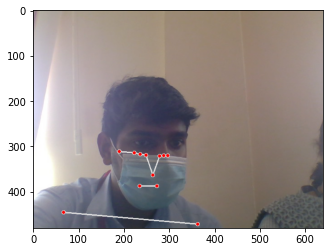

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [6]:
len(results.pose_landmarks.landmark)

NameError: name 'results' is not defined

In [7]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

NameError: name 'results' is not defined

In [12]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [13]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [14]:
face

array([0., 0., 0., ..., 0., 0., 0.])

In [55]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) #flattened array

In [56]:
result_test = extract_keypoints(results)

NameError: name 'results' is not defined

In [17]:
result_test

array([ 0.41403753,  0.75771356, -1.52395034, ...,  0.        ,
        0.        ,  0.        ])

In [18]:
np.save('0', result_test)

In [57]:
np.load('0.npy')

array([ 0.41403753,  0.75771356, -1.52395034, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [58]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [59]:
# hello
## 0
## 1
## 2
## ...
## 29
# thanks

# I love you

In [60]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [78]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [61]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [62]:
label_map = {label:num for num, label in enumerate(actions)}

In [63]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [64]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [65]:
np.array(sequences).shape

(90, 30, 1662)

In [66]:
np.array(labels).shape

(90,)

In [67]:
X = np.array(sequences)

In [68]:
X.shape

(90, 30, 1662)

In [69]:
y = to_categorical(labels).astype(int)

In [70]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [72]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [74]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [75]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [76]:
res = [.7, 0.2, 0.1]

In [77]:
actions[np.argmax(res)]

'hello'

In [78]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [48]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 3s 95ms/step - loss: 4.5940 - categorical_accuracy: 0.3412
Epoch 2/2000
3/3 [==============================] - 0s 85ms/step - loss: 3.8023 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 0s 83ms/step - loss: 5.3756 - categorical_accuracy: 0.4235
Epoch 4/2000
3/3 [==============================] - 0s 80ms/step - loss: 4.2374 - categorical_accuracy: 0.3529
Epoch 5/2000
3/3 [==============================] - 0s 82ms/step - loss: 2.6323 - categorical_accuracy: 0.2941
Epoch 6/2000
3/3 [==============================] - 0s 81ms/step - loss: 4.6155 - categorical_accuracy: 0.3765
Epoch 7/2000
3/3 [==============================] - 0s 84ms/step - loss: 1.4920 - categorical_accuracy: 0.2941
Epoch 8/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.3804 - categorical_accuracy: 0.4471
Epoch 9/2000
3/3 [==============================] - 0s 85ms/step - loss: 0.9356 - categorical_accuracy: 0.5176
E

3/3 [==============================] - 0s 85ms/step - loss: 1.0531 - categorical_accuracy: 0.4118
Epoch 147/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.0706 - categorical_accuracy: 0.3765
Epoch 148/2000
3/3 [==============================] - 0s 81ms/step - loss: 3.0314 - categorical_accuracy: 0.4000
Epoch 149/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.8294 - categorical_accuracy: 0.4235
Epoch 150/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.0821 - categorical_accuracy: 0.4471
Epoch 151/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.1144 - categorical_accuracy: 0.5059
Epoch 152/2000
3/3 [==============================] - 0s 80ms/step - loss: 1.1122 - categorical_accuracy: 0.5294
Epoch 153/2000
3/3 [==============================] - 0s 81ms/step - loss: 1.0938 - categorical_accuracy: 0.5294
Epoch 154/2000
3/3 [==============================] - 0s 83ms/step - loss: 1.1558 - categorical_accuracy: 0.494

3/3 [==============================] - 0s 92ms/step - loss: 0.7347 - categorical_accuracy: 0.6706
Epoch 291/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.8828 - categorical_accuracy: 0.6588
Epoch 292/2000
3/3 [==============================] - 0s 92ms/step - loss: 1.1998 - categorical_accuracy: 0.3294
Epoch 293/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.9726 - categorical_accuracy: 0.3412
Epoch 294/2000
3/3 [==============================] - 0s 93ms/step - loss: 1.0354 - categorical_accuracy: 0.3412
Epoch 295/2000
3/3 [==============================] - 0s 97ms/step - loss: 1.0488 - categorical_accuracy: 0.3294
Epoch 296/2000
3/3 [==============================] - 0s 93ms/step - loss: 1.0431 - categorical_accuracy: 0.3412
Epoch 297/2000
3/3 [==============================] - 0s 92ms/step - loss: 1.0384 - categorical_accuracy: 0.3412
Epoch 298/2000
3/3 [==============================] - 0s 95ms/step - loss: 1.0350 - categorical_accuracy: 0.341

3/3 [==============================] - 0s 103ms/step - loss: 1.0783 - categorical_accuracy: 0.3882
Epoch 435/2000
3/3 [==============================] - 0s 125ms/step - loss: 1.0609 - categorical_accuracy: 0.4000
Epoch 436/2000
3/3 [==============================] - 0s 114ms/step - loss: 1.0521 - categorical_accuracy: 0.3765
Epoch 437/2000
3/3 [==============================] - 0s 97ms/step - loss: 1.0464 - categorical_accuracy: 0.3765
Epoch 438/2000
3/3 [==============================] - 0s 107ms/step - loss: 1.0433 - categorical_accuracy: 0.3765
Epoch 439/2000
3/3 [==============================] - 0s 110ms/step - loss: 1.0386 - categorical_accuracy: 0.3765
Epoch 440/2000
3/3 [==============================] - 0s 97ms/step - loss: 1.0318 - categorical_accuracy: 0.4000
Epoch 441/2000
3/3 [==============================] - 0s 88ms/step - loss: 1.0236 - categorical_accuracy: 0.4118
Epoch 442/2000
3/3 [==============================] - 0s 90ms/step - loss: 1.0131 - categorical_accuracy: 

3/3 [==============================] - 0s 95ms/step - loss: 0.1195 - categorical_accuracy: 0.9647
Epoch 579/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.1149 - categorical_accuracy: 0.9647
Epoch 580/2000
3/3 [==============================] - 0s 87ms/step - loss: 0.1084 - categorical_accuracy: 0.9647
Epoch 581/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.1062 - categorical_accuracy: 0.9647
Epoch 582/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.1010 - categorical_accuracy: 0.9647
Epoch 583/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.1035 - categorical_accuracy: 0.9765
Epoch 584/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.0923 - categorical_accuracy: 0.9765
Epoch 585/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.0992 - categorical_accuracy: 0.9765
Epoch 586/2000
3/3 [==============================] - 0s 80ms/step - loss: 0.0851 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 98ms/step - loss: 0.1016 - categorical_accuracy: 0.9765
Epoch 723/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.0879 - categorical_accuracy: 0.9882
Epoch 724/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.0801 - categorical_accuracy: 0.9882
Epoch 725/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.0766 - categorical_accuracy: 0.9882
Epoch 726/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.0665 - categorical_accuracy: 0.9882
Epoch 727/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.0665 - categorical_accuracy: 0.9882
Epoch 728/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.0636 - categorical_accuracy: 0.9882
Epoch 729/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.0574 - categorical_accuracy: 0.9882
Epoch 730/2000
3/3 [==============================] - 0s 89ms/step - loss: 0.0547 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 97ms/step - loss: 8.4316e-04 - categorical_accuracy: 1.0000
Epoch 867/2000
3/3 [==============================] - 0s 90ms/step - loss: 8.1118e-04 - categorical_accuracy: 1.0000
Epoch 868/2000
3/3 [==============================] - 0s 86ms/step - loss: 7.8881e-04 - categorical_accuracy: 1.0000
Epoch 869/2000
3/3 [==============================] - 0s 85ms/step - loss: 7.6835e-04 - categorical_accuracy: 1.0000
Epoch 870/2000
3/3 [==============================] - 0s 83ms/step - loss: 7.3948e-04 - categorical_accuracy: 1.0000
Epoch 871/2000
3/3 [==============================] - 0s 88ms/step - loss: 7.1643e-04 - categorical_accuracy: 1.0000
Epoch 872/2000
3/3 [==============================] - 0s 86ms/step - loss: 6.9116e-04 - categorical_accuracy: 1.0000
Epoch 873/2000
3/3 [==============================] - 0s 84ms/step - loss: 6.7313e-04 - categorical_accuracy: 1.0000
Epoch 874/2000
3/3 [==============================] - 0s 88ms/step - loss: 6.53

3/3 [==============================] - 0s 85ms/step - loss: 1.8693e-04 - categorical_accuracy: 1.0000
Epoch 937/2000
3/3 [==============================] - 0s 86ms/step - loss: 1.8482e-04 - categorical_accuracy: 1.0000
Epoch 938/2000
3/3 [==============================] - 0s 96ms/step - loss: 1.8271e-04 - categorical_accuracy: 1.0000
Epoch 939/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.8098e-04 - categorical_accuracy: 1.0000
Epoch 940/2000
3/3 [==============================] - 0s 89ms/step - loss: 1.7874e-04 - categorical_accuracy: 1.0000
Epoch 941/2000
3/3 [==============================] - 0s 86ms/step - loss: 1.7684e-04 - categorical_accuracy: 1.0000
Epoch 942/2000
3/3 [==============================] - 0s 105ms/step - loss: 1.7475e-04 - categorical_accuracy: 1.0000
Epoch 943/2000
3/3 [==============================] - 0s 106ms/step - loss: 1.7317e-04 - categorical_accuracy: 1.0000
Epoch 944/2000
3/3 [==============================] - 0s 90ms/step - loss: 1

3/3 [==============================] - 0s 82ms/step - loss: 9.8307e-05 - categorical_accuracy: 1.0000
Epoch 1007/2000
3/3 [==============================] - 0s 83ms/step - loss: 9.7700e-05 - categorical_accuracy: 1.0000
Epoch 1008/2000
3/3 [==============================] - 0s 82ms/step - loss: 9.6580e-05 - categorical_accuracy: 1.0000
Epoch 1009/2000
3/3 [==============================] - 0s 81ms/step - loss: 9.5968e-05 - categorical_accuracy: 1.0000
Epoch 1010/2000
3/3 [==============================] - 0s 85ms/step - loss: 9.5344e-05 - categorical_accuracy: 1.0000
Epoch 1011/2000
3/3 [==============================] - 0s 82ms/step - loss: 9.4432e-05 - categorical_accuracy: 1.0000
Epoch 1012/2000
3/3 [==============================] - 0s 86ms/step - loss: 9.3639e-05 - categorical_accuracy: 1.0000
Epoch 1013/2000
3/3 [==============================] - 0s 85ms/step - loss: 9.2817e-05 - categorical_accuracy: 1.0000
Epoch 1014/2000
3/3 [==============================] - 0s 85ms/step - lo

3/3 [==============================] - 0s 85ms/step - loss: 3.9652e-05 - categorical_accuracy: 1.0000
Epoch 1145/2000
3/3 [==============================] - 0s 84ms/step - loss: 3.9442e-05 - categorical_accuracy: 1.0000
Epoch 1146/2000
3/3 [==============================] - 0s 84ms/step - loss: 3.9269e-05 - categorical_accuracy: 1.0000
Epoch 1147/2000
3/3 [==============================] - 0s 79ms/step - loss: 3.9064e-05 - categorical_accuracy: 1.0000
Epoch 1148/2000
3/3 [==============================] - 0s 80ms/step - loss: 3.8861e-05 - categorical_accuracy: 1.0000
Epoch 1149/2000
3/3 [==============================] - 0s 83ms/step - loss: 3.8644e-05 - categorical_accuracy: 1.0000
Epoch 1150/2000
3/3 [==============================] - 0s 81ms/step - loss: 3.8435e-05 - categorical_accuracy: 1.0000
Epoch 1151/2000
3/3 [==============================] - 0s 82ms/step - loss: 3.8249e-05 - categorical_accuracy: 1.0000
Epoch 1152/2000
3/3 [==============================] - 0s 81ms/step - lo

3/3 [==============================] - 0s 86ms/step - loss: 2.0702e-05 - categorical_accuracy: 1.0000
Epoch 1283/2000
3/3 [==============================] - 0s 81ms/step - loss: 2.0615e-05 - categorical_accuracy: 1.0000
Epoch 1284/2000
3/3 [==============================] - 0s 80ms/step - loss: 2.0540e-05 - categorical_accuracy: 1.0000
Epoch 1285/2000
3/3 [==============================] - 0s 80ms/step - loss: 2.0440e-05 - categorical_accuracy: 1.0000
Epoch 1286/2000
3/3 [==============================] - 0s 86ms/step - loss: 2.0369e-05 - categorical_accuracy: 1.0000
Epoch 1287/2000
3/3 [==============================] - 0s 83ms/step - loss: 2.0281e-05 - categorical_accuracy: 1.0000
Epoch 1288/2000
3/3 [==============================] - 0s 81ms/step - loss: 2.0197e-05 - categorical_accuracy: 1.0000
Epoch 1289/2000
3/3 [==============================] - 0s 78ms/step - loss: 2.0118e-05 - categorical_accuracy: 1.0000
Epoch 1290/2000
3/3 [==============================] - 0s 82ms/step - lo

3/3 [==============================] - 0s 86ms/step - loss: 1.1788e-05 - categorical_accuracy: 1.0000
Epoch 1421/2000
3/3 [==============================] - 0s 91ms/step - loss: 1.1736e-05 - categorical_accuracy: 1.0000
Epoch 1422/2000
3/3 [==============================] - 0s 87ms/step - loss: 1.1690e-05 - categorical_accuracy: 1.0000
Epoch 1423/2000
3/3 [==============================] - 0s 174ms/step - loss: 1.1637e-05 - categorical_accuracy: 1.0000
Epoch 1424/2000
3/3 [==============================] - 0s 78ms/step - loss: 1.1584e-05 - categorical_accuracy: 1.0000
Epoch 1425/2000
3/3 [==============================] - 0s 82ms/step - loss: 1.1525e-05 - categorical_accuracy: 1.0000
Epoch 1426/2000
3/3 [==============================] - 0s 90ms/step - loss: 1.1477e-05 - categorical_accuracy: 1.0000
Epoch 1427/2000
3/3 [==============================] - 0s 91ms/step - loss: 1.1443e-05 - categorical_accuracy: 1.0000
Epoch 1428/2000
3/3 [==============================] - 0s 92ms/step - l

3/3 [==============================] - 0s 93ms/step - loss: 6.9027e-06 - categorical_accuracy: 1.0000
Epoch 1559/2000
3/3 [==============================] - 0s 99ms/step - loss: 6.8761e-06 - categorical_accuracy: 1.0000
Epoch 1560/2000
3/3 [==============================] - 0s 86ms/step - loss: 6.8466e-06 - categorical_accuracy: 1.0000
Epoch 1561/2000
3/3 [==============================] - 0s 88ms/step - loss: 6.8284e-06 - categorical_accuracy: 1.0000
Epoch 1562/2000
3/3 [==============================] - 0s 86ms/step - loss: 6.8115e-06 - categorical_accuracy: 1.0000
Epoch 1563/2000
3/3 [==============================] - 0s 94ms/step - loss: 6.7737e-06 - categorical_accuracy: 1.0000
Epoch 1564/2000
3/3 [==============================] - 0s 82ms/step - loss: 6.7414e-06 - categorical_accuracy: 1.0000
Epoch 1565/2000
3/3 [==============================] - 0s 89ms/step - loss: 6.7204e-06 - categorical_accuracy: 1.0000
Epoch 1566/2000
3/3 [==============================] - 0s 89ms/step - lo

3/3 [==============================] - 0s 99ms/step - loss: 4.3265e-06 - categorical_accuracy: 1.0000
Epoch 1697/2000
3/3 [==============================] - 0s 99ms/step - loss: 4.3139e-06 - categorical_accuracy: 1.0000
Epoch 1698/2000
3/3 [==============================] - 0s 97ms/step - loss: 4.3013e-06 - categorical_accuracy: 1.0000
Epoch 1699/2000
3/3 [==============================] - 0s 93ms/step - loss: 4.2873e-06 - categorical_accuracy: 1.0000
Epoch 1700/2000
3/3 [==============================] - 0s 89ms/step - loss: 4.2690e-06 - categorical_accuracy: 1.0000
Epoch 1701/2000
3/3 [==============================] - 0s 92ms/step - loss: 4.2564e-06 - categorical_accuracy: 1.0000
Epoch 1702/2000
3/3 [==============================] - 0s 97ms/step - loss: 4.2452e-06 - categorical_accuracy: 1.0000
Epoch 1703/2000
3/3 [==============================] - 0s 99ms/step - loss: 4.2298e-06 - categorical_accuracy: 1.0000
Epoch 1704/2000
3/3 [==============================] - 0s 92ms/step - lo

3/3 [==============================] - 0s 85ms/step - loss: 2.9704e-06 - categorical_accuracy: 1.0000
Epoch 1835/2000
3/3 [==============================] - 0s 84ms/step - loss: 2.9606e-06 - categorical_accuracy: 1.0000
Epoch 1836/2000
3/3 [==============================] - 0s 86ms/step - loss: 2.9550e-06 - categorical_accuracy: 1.0000
Epoch 1837/2000
3/3 [==============================] - 0s 92ms/step - loss: 2.9479e-06 - categorical_accuracy: 1.0000
Epoch 1838/2000
3/3 [==============================] - 0s 96ms/step - loss: 2.9423e-06 - categorical_accuracy: 1.0000
Epoch 1839/2000
3/3 [==============================] - 0s 93ms/step - loss: 2.9339e-06 - categorical_accuracy: 1.0000
Epoch 1840/2000
3/3 [==============================] - 0s 96ms/step - loss: 2.9269e-06 - categorical_accuracy: 1.0000
Epoch 1841/2000
3/3 [==============================] - 0s 105ms/step - loss: 2.9199e-06 - categorical_accuracy: 1.0000
Epoch 1842/2000
3/3 [==============================] - 0s 95ms/step - l

3/3 [==============================] - 0s 98ms/step - loss: 2.1556e-06 - categorical_accuracy: 1.0000
Epoch 1973/2000
3/3 [==============================] - 0s 95ms/step - loss: 2.1514e-06 - categorical_accuracy: 1.0000
Epoch 1974/2000
3/3 [==============================] - 0s 101ms/step - loss: 2.1457e-06 - categorical_accuracy: 1.0000
Epoch 1975/2000
3/3 [==============================] - 0s 111ms/step - loss: 2.1415e-06 - categorical_accuracy: 1.0000
Epoch 1976/2000
3/3 [==============================] - 0s 105ms/step - loss: 2.1359e-06 - categorical_accuracy: 1.0000
Epoch 1977/2000
3/3 [==============================] - 0s 95ms/step - loss: 2.1331e-06 - categorical_accuracy: 1.0000
Epoch 1978/2000
3/3 [==============================] - 0s 88ms/step - loss: 2.1233e-06 - categorical_accuracy: 1.0000
Epoch 1979/2000
3/3 [==============================] - 0s 100ms/step - loss: 2.1219e-06 - categorical_accuracy: 1.0000
Epoch 1980/2000
3/3 [==============================] - 0s 86ms/step 

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

# 8. Make Predictions

In [80]:
res = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [82]:
actions[np.argmax(res[1])]

'hello'

In [85]:
actions[np.argmax(y_test[1])]

'hello'

# 9. Save Weights

In [87]:
model.save('action.h5')

In [49]:
del model

In [88]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [89]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [90]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 38ms/step


In [91]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [92]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[2, 0],
        [0, 3]]], dtype=int64)

In [93]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [94]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [95]:
import pyttsx3

In [57]:
pyobj = pyttsx3.init()
def text_to_voice(sentence):
    if sentence[-1] != sentence[-2]:
        pyobj.say(sentence[-1])
        pyobj.runAndWait()

In [56]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1296x1296 with 0 Axes>

In [57]:
sequence.reverse()

AttributeError: 'int' object has no attribute 'reverse'

In [102]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
#         text to Voice
#         if len(sentence) > 2:
#             text_to_voice(sentence)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 47ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 48ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 47ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 48ms/step
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 46ms/step
<class 'mediapipe.p

In [97]:
cap.release()
cv2.destroyAllWindows()

In [64]:
res[np.argmax(res)] > threshold

True

In [73]:
import pyttsx3
pyobj = pyttsx3.init()
pyobj.say("thanks")
pyobj.runAndWait()

In [60]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 51ms/step


array([[6.8014103e-08, 9.9999881e-01, 1.0708496e-06]], dtype=float32)